In [6]:
import pandas as pd

df = pd.read_csv("steam_games_data_cleaned.csv")
df = df[["name", "genres"]]
df

,name,genres
0,Counter-Strike,['Action']
1,Team Fortress Classic,['Action']
2,Day of Defeat,['Action']
3,Deathmatch Classic,['Action']
4,Half-Life: Opposing Force,['Action']
...,...,...
10408,Summer Crush,['Indie']
10409,Yet Another Zombie Survivors,"['Action', 'Casual', 'Indie', 'RPG']"
10410,Tales of Spark,"['Action', 'Adventure', 'Indie', 'RPG']"
10411,Taora : Survival,"['Action', 'Adventure', 'RPG', 'Simulation']"


In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np
import pickle

def prepare_data(df, embedding_file):
    with open(embedding_file, "rb") as f:
        embeddings = pickle.load(f)
    labels = df["genres"]
    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(labels)

    return embeddings, y

In [3]:
X, y = prepare_data(df, "bert_embeddings.pkl")

print(f"Total samples: {len(X)}")

Total samples: 10413


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

base_classifier = LogisticRegression(random_state=42)
clf = OneVsRestClassifier(base_classifier, n_jobs=-1)

In [5]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import jaccard_score, make_scorer

result = cross_validate(clf, X, y, cv=5, scoring=make_scorer(jaccard_score,average='samples'), n_jobs=-1)
np.mean(result["test_score"])

Exception ignored in: <function _get_module_lock.<locals>.cb at 0x7f0fd74b18a0>
Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 454, in cb
KeyboardInterrupt: 
Exception ignored in: <function ResourceTracker.__del__ at 0x7f2458977a60>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f107af77a60>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessErro

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

base_classifier = RandomForestClassifier(class_weight="balanced", random_state=42)
clf = OneVsRestClassifier(base_classifier, n_jobs=-1)

result = cross_validate(clf, X, y, cv=5, scoring=make_scorer(jaccard_score,average='samples'), n_jobs=-1)
np.mean(result["test_score"])

/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 11 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 11 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 1 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 1 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 1 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 10 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 10 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclas

KeyboardInterrupt: 

In [ ]:
# PyTorch multilabel classifier (MLP) training and evaluation
import math
import numpy as np

# Optional: if sklearn metrics not in scope (cell re-run independently)
try:
    from sklearn.metrics import accuracy_score, jaccard_score, hamming_loss
except Exception:
    pass

# 1) Resolve labels: use filtered labels if they exist (to avoid constant columns), else fallback to full labels
try:
    y_tr = y_train_filtered
    y_te = y_test_filtered
except NameError:
    y_tr = y_train
    y_te = y_test

num_features = int(X_train.shape[1])
num_labels = int(y_tr.shape[1])

# 2) Build PyTorch Dataset/DataLoader
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

# Tensors
X_train_t = torch.from_numpy(X_train).float()
X_test_t = torch.from_numpy(X_test).float()
y_train_t = torch.from_numpy(y_tr).float()
y_test_t = torch.from_numpy(y_te).float()

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)

# 3) Model (now supports arbitrary hidden layers)
class MLP(nn.Module):
    def __init__(self, in_dim: int, out_dim: int, hidden_layers=(256, 128), dropout: float = 0.2):
        super().__init__()
        layers = []
        prev = in_dim
        for h in hidden_layers:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, out_dim))  # logits for BCEWithLogitsLoss
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# 4) Loss (with class imbalance handling via pos_weight)
# pos_weight = (N - pos) / pos; add epsilon to avoid div-by-zero
with torch.no_grad():
    pos = y_train_t.sum(dim=0)
    neg = y_train_t.shape[0] - pos
    eps = 1e-6
    pos_weight = (neg / (pos + eps)).clamp(min=0.0, max=1e6)

# 5) Train loop
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(num_features, num_labels, hidden_layers=(32,), dropout=0.5).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

epochs = 200  # increase for better results if time allows

def evaluate(model, loader, threshold: float = 0.5):
    model.eval()
    all_logits = []
    all_targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            all_logits.append(logits.cpu())
            all_targets.append(yb.cpu())
    logits = torch.cat(all_logits, dim=0)
    targets = torch.cat(all_targets, dim=0)
    probs = torch.sigmoid(logits)
    preds = (probs >= threshold).float()
    return preds.numpy().astype(int), targets.numpy().astype(int)

best_val = math.inf
train_losses = []
val_losses = []
for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(float(train_loss))

    # simple validation loss for scheduling
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_running_loss += loss.item() * xb.size(0)
    val_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(float(val_loss))

    scheduler.step(val_loss)

    print(f"Epoch {epoch:02d}/{epochs} - train_loss: {train_loss:.4f}  val_loss: {val_loss:.4f}")

# 6) Evaluation metrics on test set
# Use same metrics as earlier cells for apples-to-apples comparison
pred_np, tgt_np = evaluate(model, val_loader, threshold=0.5)

acc = accuracy_score(tgt_np, pred_np)
jaccard = jaccard_score(tgt_np, pred_np, average="samples")
hamming = hamming_loss(tgt_np, pred_np)

print(f"[PyTorch MLP] Acc: {acc:.4f}, Jaccard: {jaccard:.4f}, Hamming: {hamming:.4f}")

Epoch 01/200 - train_loss: 0.6362  val_loss: 0.6317
Epoch 02/200 - train_loss: 0.6262  val_loss: 0.6163
Epoch 03/200 - train_loss: 0.6092  val_loss: 0.5944
Epoch 04/200 - train_loss: 0.5900  val_loss: 0.5732
Epoch 05/200 - train_loss: 0.5747  val_loss: 0.5569
Epoch 06/200 - train_loss: 0.5635  val_loss: 0.5455
Epoch 07/200 - train_loss: 0.5552  val_loss: 0.5376
Epoch 08/200 - train_loss: 0.5488  val_loss: 0.5315
Epoch 09/200 - train_loss: 0.5433  val_loss: 0.5260
Epoch 10/200 - train_loss: 0.5407  val_loss: 0.5224
Epoch 11/200 - train_loss: 0.5366  val_loss: 0.5191
Epoch 12/200 - train_loss: 0.5339  val_loss: 0.5166
Epoch 13/200 - train_loss: 0.5327  val_loss: 0.5142
Epoch 14/200 - train_loss: 0.5307  val_loss: 0.5128
Epoch 15/200 - train_loss: 0.5286  val_loss: 0.5113
Epoch 16/200 - train_loss: 0.5254  val_loss: 0.5094
Epoch 17/200 - train_loss: 0.5248  val_loss: 0.5082
Epoch 18/200 - train_loss: 0.5221  val_loss: 0.5066
Epoch 19/200 - train_loss: 0.5214  val_loss: 0.5054
Epoch 20/200

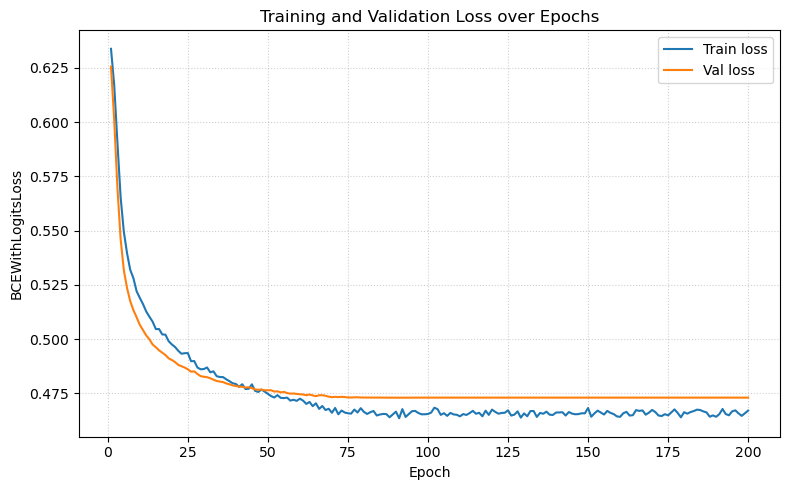

In [ ]:
# Plot losses over epochs
import matplotlib.pyplot as plt

epochs_axis = list(range(1, len(train_losses) + 1))
plt.figure(figsize=(8, 5))
plt.plot(epochs_axis, train_losses, label="Train loss")
plt.plot(epochs_axis, val_losses, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("BCEWithLogitsLoss")
plt.title("Training and Validation Loss over Epochs")
plt.grid(True, linestyle=":", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
X, y = prepare_data(df, "tfidf_embeddings.pkl")

print(f"Total samples: {X.shape[0]}")

Total samples: 10413


In [ ]:
base_classifier = LogisticRegression(random_state=42)
clf = OneVsRestClassifier(base_classifier, n_jobs=-1)
result = cross_validate(clf, X, y, cv=5, scoring=make_scorer(jaccard_score,average='samples'), n_jobs=-1)
np.mean(result["test_score"])

/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 1 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 10 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 11 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 11 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 11 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 1 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 10 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multicla

np.float64(0.7682259907221702)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import jaccard_score, make_scorer
import numpy as np

X, y = prepare_data(df, "bow_embeddings.pkl")
print(f"Total samples: {X.shape[0]}")

base_classifier = LogisticRegression(random_state=42)
clf = OneVsRestClassifier(base_classifier, n_jobs=-1)
result = cross_validate(clf, X, y, cv=5, scoring=make_scorer(jaccard_score,average='samples'), n_jobs=-1)
np.mean(result["test_score"])

Total samples: 10413


/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 11 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 10 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 1 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 1 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 11 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 1 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclass.py:90: UserWarning: Label 11 is present in all training examples.
  warnings.warn(
/usr/lib/python3.13/site-packages/sklearn/multiclas

np.float64(0.739272304489448)

Exception ignored in: <function ResourceTracker.__del__ at 0x7fb2b757ba60>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fbc8a06fa60>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f39cbf77a60>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/reso